# Import all necessary libraries

In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.nn as nn
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import torch.nn.functional as F
import torch.nn as nn
import time
import subprocess

# Data augmentation and Data loading

In [ ]:
#with data augmentation
'''transform = transforms.Compose([
    transforms.RandomRotation(degrees=50),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((64,64)),
    transforms.ToTensor()
    
])'''
#without data augmentation
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
    
])
train_image_path = Path('mvtec_anomaly_detection/tile/train')
good_dataset = ImageFolder(root=train_image_path, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

# Set the batch size
BS = 16

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True)


# Load a pretrained Model

torch.Size([1, 40, 8, 8])
torch.Size([1, 80, 4, 4])
torch.Size([1, 120, 64, 64])


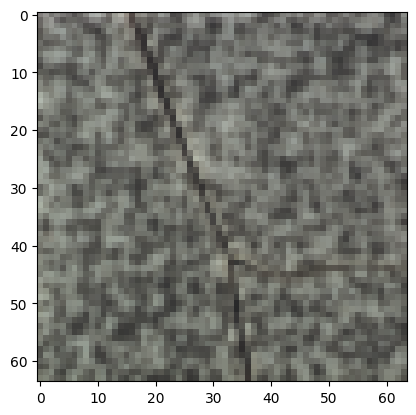

In [ ]:


# MobileNetV3 feature extractor class
class mobilenetv3_feature_extractor(nn.Module):
    def __init__(self):
        super(mobilenetv3_feature_extractor, self).__init__()
        # Load pre-trained MobileNetV3 large
        self.model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)

        # Set to evaluation mode and freeze layers
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

        # Hook to extract feature maps
        def hook(module, input, output) -> None:
            self.features.append(output)

        # Register hooks for layers to extract feature maps
        self.model.features[4].register_forward_hook(hook)  # Layer after feature block 4
        self.model.features[7].register_forward_hook(hook)  # Layer after feature block 7

        # Adaptive pooling to match the size of feature maps (64x64)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((64, 64))  # Resize to (64, 64)

    def forward(self, input):
        self.features = []  # Reset features list before every forward pass

        with torch.no_grad():
            _ = self.model(input)

        # Resize the feature maps to match the same spatial dimensions (64x64)
        resized_features = [self.adaptive_pool(fmap) for fmap in self.features]
        
        # Concatenate feature maps along the channel axis
        patch = torch.cat(resized_features, 1)

        return patch

# Load and transform the image (resize to 64x64)
image = Image.open(r'C:\Swapnil\Dissertation\mvtec_anomaly_detection\tile\test\crack\000.png')
image = transform(image).unsqueeze(0)  # Add batch dimension

# Initialize the MobileNetV3 feature extractor
backbone = mobilenetv3_feature_extractor().cuda()

# Extract feature maps
feature = backbone(image.cuda())

# Print feature shapes
print(backbone.features[0].shape)  # Shape of feature map after layer 4
print(backbone.features[1].shape)  # Shape of feature map after layer 7
print(feature.shape)  # Final concatenated feature map shape

# Visualize the input image
plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())  # Reorder dimensions for visualization
plt.show()


torch.Size([1, 40, 8, 8])
torch.Size([1, 80, 4, 4])
torch.Size([1, 120, 64, 64])


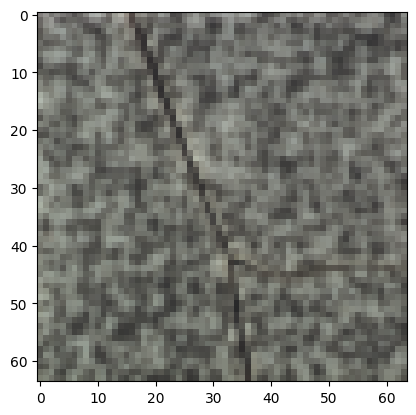

In [4]:


image = Image.open(r'C:\Swapnil\Dissertation\mvtec_anomaly_detection\tile\test\crack\000.png')
image = transform(image).unsqueeze(0)

backbone = mobilenetv3_feature_extractor()
feature = backbone(image)

print(backbone.features[0].shape)
print(backbone.features[1].shape)

print(feature.shape)

plt.imshow(image[0].permute(1,2,0))

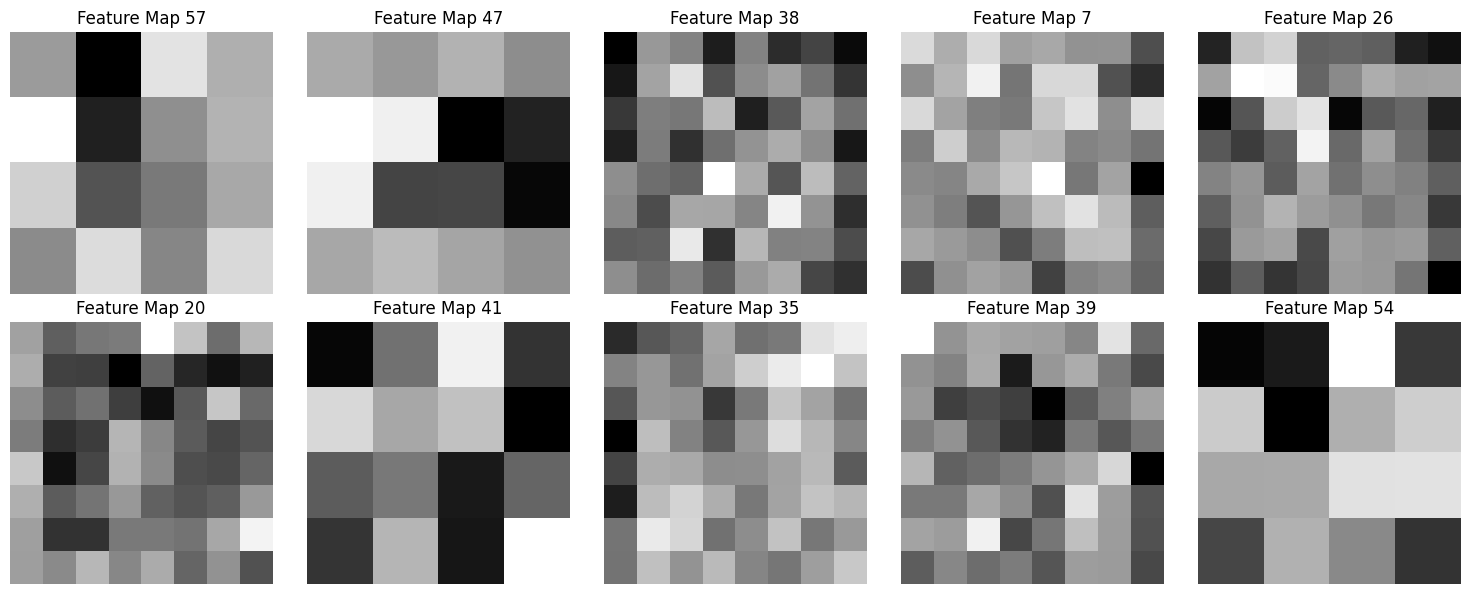

In [5]:

# Select 10 random indices for feature maps
indices = torch.randperm(64)[:10]

# Plot the selected feature maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(feature[0,idx].detach().cpu(), cmap='gray')
    axes[row, col].set_title(f'Feature Map {idx}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

# The autoencoder model

Epoch [1/100], Train Loss: 7.6411, Validation Loss: 7.8374
Epoch [2/100], Train Loss: 5.2287, Validation Loss: 4.8610
Epoch [3/100], Train Loss: 3.7363, Validation Loss: 3.4122
Epoch [4/100], Train Loss: 2.8322, Validation Loss: 2.6544
Epoch [5/100], Train Loss: 2.2822, Validation Loss: 2.2043
Epoch [6/100], Train Loss: 1.9267, Validation Loss: 1.8737
Epoch [7/100], Train Loss: 1.6886, Validation Loss: 1.6464
Epoch [8/100], Train Loss: 1.5073, Validation Loss: 1.4957
Epoch [9/100], Train Loss: 1.3770, Validation Loss: 1.3596
Epoch [10/100], Train Loss: 1.2629, Validation Loss: 1.2543
Epoch [11/100], Train Loss: 1.1782, Validation Loss: 1.1734
Epoch [12/100], Train Loss: 1.1041, Validation Loss: 1.1075
Epoch [13/100], Train Loss: 1.0452, Validation Loss: 1.0619
Epoch [14/100], Train Loss: 0.9976, Validation Loss: 1.0182
Epoch [15/100], Train Loss: 0.9517, Validation Loss: 0.9694
Epoch [16/100], Train Loss: 0.9112, Validation Loss: 0.9327
Epoch [17/100], Train Loss: 0.8749, Validation Lo

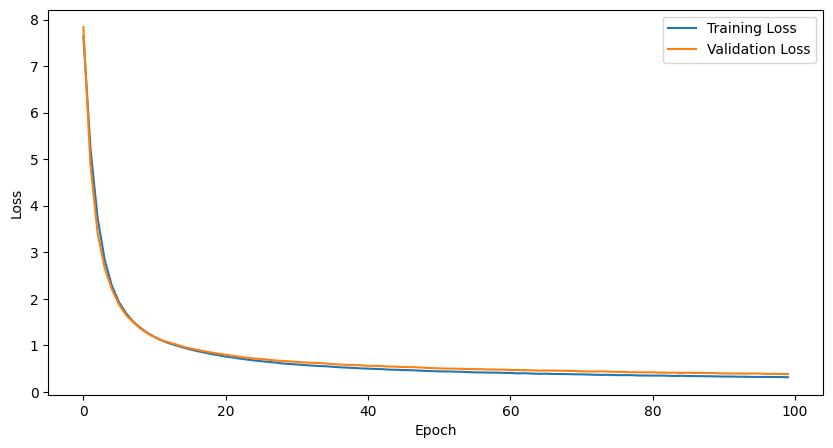

In [ ]:

# autoencoder class
class FeatCAE(nn.Module):
    """Autoencoder."""
    def __init__(self, in_channels=120, latent_dim=50, is_bn=True):
        super(FeatCAE, self).__init__()

        # Encoder
        layers = []
        layers += [nn.Conv2d(in_channels, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, latent_dim, kernel_size=1, stride=1, padding=0)]

        self.encoder = nn.Sequential(*layers)

        # Decoder
        layers = []
        layers += [nn.Conv2d(latent_dim, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, in_channels, kernel_size=1, stride=1, padding=0)]

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Move backbone and model to GPU
backbone.cuda()
model = FeatCAE(in_channels=120, latent_dim=100).cuda()

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
Loss = []
Validation_Loss = []

for epoch in range(num_epochs):
    model.train()
    train_loss_sum = 0.0
    num_batches = 0

    # Iterate over training data
    for data, _ in train_loader:
        with torch.no_grad():
            features = backbone(data.cuda())  # Extract features with 120 channels

        # Forward pass through the autoencoder
        output = model(features)
        
        # Compute loss
        loss = criterion(output, features)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        num_batches += 1

    avg_train_loss = train_loss_sum / num_batches
    Loss.append(avg_train_loss)

    # Validation loop
    model.eval()
    val_loss_sum = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for data, _ in test_loader:
            features = backbone(data.cuda())  # Extract features from backbone
            output = model(features)  # Pass features through autoencoder
            val_loss = criterion(output, features)  # Compute validation loss
            val_loss_sum += val_loss.item()
            num_val_batches += 1

    avg_val_loss = val_loss_sum / num_val_batches
    Validation_Loss.append(avg_val_loss)

    # Print epoch progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


# Plotting loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(Loss, label="Training Loss")
plt.plot(Validation_Loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#torch.save(model.state_dict(), 'model.pth')


# Prediction of heatmap

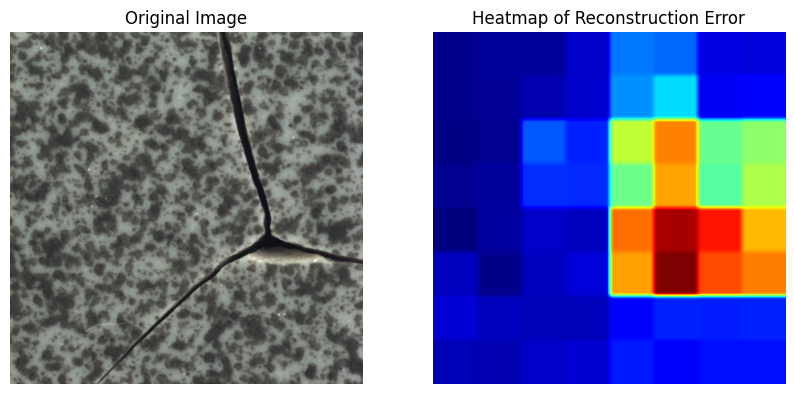

In [7]:

# Load and transform the image
image = Image.open(r'C:\Swapnil\Dissertation\mvtec_anomaly_detection\tile\test\crack\006.png')
transformed_image = transform(image).unsqueeze(0)

# Generate features and reconstruction
with torch.no_grad():
    features = backbone(transformed_image.cuda())
    recon = model(features)

# Calculate reconstruction error
recon_error = ((features - recon) ** 2).mean(axis=(1)).unsqueeze(0)

# Interpolate to match original input resolution
segm_map = torch.nn.functional.interpolate(
    recon_error,
    size=(224, 224),
    mode='bilinear'
)

# Plot the actual image and heatmap side by side
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Display the heatmap
plt.subplot(1, 2, 2)
plt.imshow(segm_map.squeeze().cpu().numpy(), cmap='jet')
plt.title('Heatmap of Reconstruction Error')
plt.axis('off')

plt.show()


# Reconstruction Error for OK images

In [8]:
def decision_function(segm_map):  

    mean_top_10_values = []

    for map in segm_map:
        # Flatten the tensor
        flattened_tensor = map.reshape(-1)

        # Sort the flattened tensor along the feature dimension (descending order)
        sorted_tensor, _ = torch.sort(flattened_tensor,descending=True)

        # Take the top 10 values along the feature dimension
        mean_top_10_value = sorted_tensor[:10].mean()

        mean_top_10_values.append(mean_top_10_value)

    return torch.stack(mean_top_10_values)

In [9]:
model.eval()

RECON_ERROR=[]
for data,_ in train_loader:
    
    with torch.no_grad():
        features = backbone(data.cuda()).squeeze()
        # Forward pass
        recon = model(features)
    # Compute the loss
    segm_map =  ((features-recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    anomaly_score = decision_function(segm_map)
    # anomaly_score = segm_map.mean(axis=(1,2))
    
    RECON_ERROR.append(anomaly_score)
    
RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

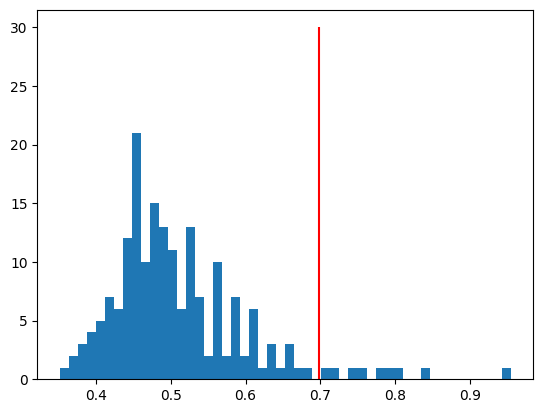

In [10]:
best_threshold = np.mean(RECON_ERROR) + 2 * np.std(RECON_ERROR)

heat_map_max, heat_map_min = np.max(RECON_ERROR), np.min(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

# Reconstruction Error for Test Images

In [11]:
y_true=[]
y_pred=[]
y_score=[]

model.eval()
backbone.eval()

test_path = Path('mvtec_anomaly_detection/tile/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)
    
    with torch.no_grad():
        features = backbone(test_image)
        # Forward pass
        recon = model(features)
    
    segm_map = ((features - recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    y_score_image = decision_function(segm_map=segm_map)
    # y_score_image = segm_map.mean(axis=(1,2))
    
    y_pred_image = 1*(y_score_image >= best_threshold)
    
    y_true_image = 0 if fault_type == 'good' else 1
    
    y_true.append(y_true_image)
    y_pred.append(y_pred_image.cpu().numpy())
    y_score.append(y_score_image.cpu().numpy())
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)
    

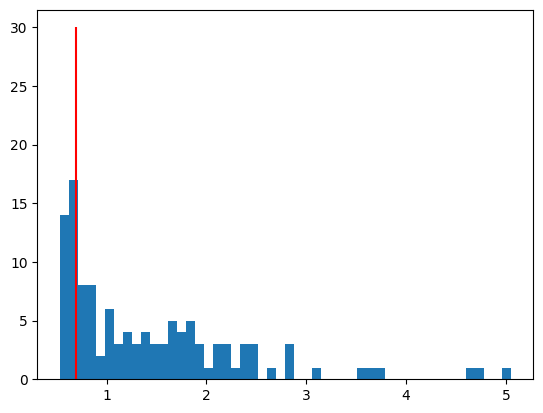

In [12]:
plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

# Performance metrics

AUC-ROC Score: 0.9426406926406926


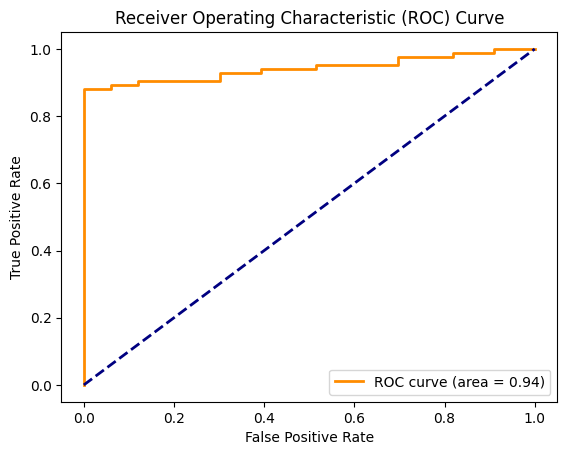

Best threshold based on F1 score = 0.8668762445449829


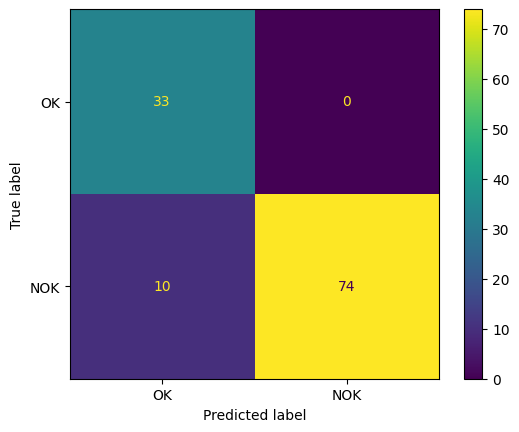

In [ ]:

if len(y_true) == 0 or len(y_score) == 0:
    print("y_true or y_score is empty, cannot calculate AUC-ROC or plot the curve.")
else:
    # Calculate AUC-ROC score
    auc_roc_score = roc_auc_score(y_true, y_score)
    print("AUC-ROC Score:", auc_roc_score)

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Calculate F1 scores for different thresholds
    f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

    # Select the best threshold based on F1 score
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f'Best threshold based on F1 score = {best_threshold}')

    # Generate confusion matrix
    cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OK', 'NOK'])
    disp.plot()
    plt.show()


In [ ]:

# Define variables for inference time and throughput
total_time = 0
num_images = 0

# Path to test images (replace with your actual test path)
test_path = Path('mvtec_anomaly_detection/hazelnut/test')

# Set model to evaluation mode
model.eval()
backbone.eval()

# Loop through each test image
for path in test_path.glob('*/*.png'):
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)  # Preprocess and load image
    
    # Measure start time
    start_time = time.time()
    
    with torch.no_grad():
        # Feature extraction with backbone
        features = backbone(test_image)
        
        # Forward pass through the autoencoder model
        recon = model(features)
        
    # Measure end time and calculate inference time
    end_time = time.time()
    inference_time = end_time - start_time
    total_time += inference_time
    num_images += 1
    
    print(f"Inference Time for {path.name}: {inference_time:.6f} seconds")

# Calculate overall throughput
average_inference_time = total_time / num_images
throughput = num_images / total_time

print(f"\nAverage Inference Time per image: {average_inference_time:.6f} seconds")
print(f"Throughput: {throughput:.2f} images per second")


Inference Time for 000.png: 0.008043 seconds
Inference Time for 001.png: 0.006618 seconds
Inference Time for 002.png: 0.005684 seconds
Inference Time for 003.png: 0.007303 seconds
Inference Time for 004.png: 0.005633 seconds
Inference Time for 005.png: 0.006131 seconds
Inference Time for 006.png: 0.005617 seconds
Inference Time for 007.png: 0.005479 seconds
Inference Time for 008.png: 0.005822 seconds
Inference Time for 009.png: 0.006128 seconds
Inference Time for 010.png: 0.003242 seconds
Inference Time for 011.png: 0.007027 seconds
Inference Time for 012.png: 0.006678 seconds
Inference Time for 013.png: 0.006291 seconds
Inference Time for 014.png: 0.005279 seconds
Inference Time for 015.png: 0.006123 seconds
Inference Time for 016.png: 0.005975 seconds
Inference Time for 017.png: 0.006029 seconds
Inference Time for 000.png: 0.006056 seconds
Inference Time for 001.png: 0.006503 seconds
Inference Time for 002.png: 0.009137 seconds
Inference Time for 003.png: 0.005188 seconds
Inference 

In [ ]:


def measure_single_inference_energy(feature_extractor, model, input_data):
    # Start timing and power measurement
    start_time = time.time()
    
    # Pass the input data through the feature extractor
    features = feature_extractor(input_data)
    
    # Run a single forward pass for inference
    _ = model(features)
    
    # Get power usage immediately after inference
    power_output = subprocess.check_output(["nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits"])
    power_usage = float(power_output.decode("utf-8").strip().split("\n")[0])  # Power in watts
    
    # End timing
    end_time = time.time()
    
    # Calculate time and energy usage for a single inference
    execution_time = end_time - start_time  # Time in seconds
    energy_usage = power_usage * execution_time  # Energy in watt-seconds (Joules)
    
    print(f"Power Consumption during Inference: {power_usage:.2f} W")
    print(f"Execution Time for Single Inference: {execution_time:.4f} s")
    print(f"Energy Consumption for Single Inference: {energy_usage:.4f} J")

input_data = torch.randn(1, 3, 64, 64).cuda()  # Example input for a single 64x64 image with 3 channels

# Ensure the feature extractor and model are on GPU
backbone.cuda()
model.cuda()

# Measure energy consumption for a single inference
measure_single_inference_energy(backbone, model, input_data)


Power Consumption during Inference: 17.21 W
Execution Time for Single Inference: 0.0525 s
Energy Consumption for Single Inference: 0.9039 J


In [ ]:

def calculate_model_size(model):
    # Calculate the number of parameters and their sizes in bytes
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()  # nelement gives count; element_size gives bytes per element
    
    # Convert bytes to megabytes
    size_in_mb = param_size / (1024 ** 2)
    print(f"Estimated Model Storage for Inference: {size_in_mb:.2f} MB")


calculate_model_size(model)


Estimated Model Storage for Inference: 0.55 MB


In [17]:
# Save the model in inference mode
torch.save(model.state_dict(), "model_inference.pt")

# Check the file size
file_size_in_mb = os.path.getsize("model_inference.pt") / (1024 ** 2)
print(f"Actual Model Storage for Inference (saved): {file_size_in_mb:.2f} MB")


Actual Model Storage for Inference (saved): 0.57 MB
